# Segmenting interlayers

* [Problem description](#description)
* [Dataset](#dataset)
* [Model architecture](#architecture)
* [Training](#training)
* [Validation](#validation)
* [Criticism](#criticism)
* [Conclusion](#conclusion)
* [Suggestions for improvements](#suggestions)

<a id='description'></a>

# Problem description
Welcome! In this notebook we train a neural network for multiclass-segmentation of *seismic interlayers*. Seismic interlayer is a layer of earth formation between two horizons, labeled by a geophysicist. In a way, a set of several horizons yields coloring of a seismic cube in different interlayers:

<img src="images/facies.png" alt="Drawing" style="width: 600px;"/>

Each seismic interlayer is thought to have roughly similar seismic reflection parameters across all of its volume. Naturally, convolutional neural networks should be able to learn patterns of a specific interlayer. As a result models, trained on a small subset of *ilines/xlines* of a seismic cube are expected to classify interlayers on unseen (during training) parts of seismic cubes with reasonable accuracy.

In [1]:
import sys
import os

In [2]:
sys.path.append('../repos/seismiqb/')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


<a id='dataset'></a>

# Dataset
we use one seismic cube `P_cube` for training/testing. One can find [here]() a description of cube `P_cube` along with some visualiztions. `P_cube` is a 3d-array of data of shape **[2737, 2599, 2001]** Along with the cube itself come 4 labeled horizons. Check out an `iline`-slice from a cube:

<img src="images/P_cube_slice.png" alt="Drawing" style="width: 600px;"/>

Importantly, for training and testing we use different sets of *ilines*: 45% of *ilines* are reserved for training while 35% of *ilines* are used for testing (we intentionally use a margin of *ilines* between training and testing parts to battle overfit).

Due to the fact that full-sized cube cannot be fit into GPU-memory, we train our model on crops of size **[128, 128, 1]**.

In the next cells we 1) set up a structure for storing information about our seismic cube `P_cube` and 2) prepare crop-sampling strategies for training and testing. 

Indexing seismic cubes: setting up `SeismicCubeset`

In [133]:
from seismiqb import SeismicCropBatch, SeismicCubeset
from seismiqb.batchflow import FilesIndex, D, L, F, Pipeline, B, V
from seismiqb import make_labels_dict, read_point_cloud

DATA_DIR = '/notebooks/data/cubes/CUBE_3/'
qbix = FilesIndex(path=os.path.join(DATA_DIR, 'P_cube.hdf5'), no_ext=True)
qbset = SeismicCubeset(qbix)

load info about seismic cubes into `SeismicCubeset`

In [143]:
qbset.load_geometries()

load horizon-labels

In [39]:
pref = os.path.join(DATA_DIR, 'HORIZONTS')
horizons_paths = [os.path.join(pref, p) for p in ['prb_B_anon.txt',
                                                  'prb_T_ALL_anon.txt',
                                                  'prb_G_anon.txt',
                                                  'prb_M_anon.txt']]

qbset.load_point_clouds(paths={qbset.indices[0]: horizons_paths}, names=['cdp_x', 'cdp_y', 'height'])
qbset.load_labels()

make train/test samplers of crop-locations

In [40]:
qbset.load_samplers()

In [ ]:
qbset.train_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                            high=[1, 0.45, 1]).sample
qbset.test_sample = qbset.sampler.truncate(expr=lambda x: x[:, 1:],
                                           low=[0, 0.65, 0]).sample

`pipeline` for loading cube crops and building segmentation-masks

In [155]:
wflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('train_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).swapaxes(1, 2).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

<a id='architecture'></a>

# Model architecture
We use a convolutional neural network [`U-net`](https://arxiv.org/abs/1505.04597) for interlayers segmentation.

In [45]:
from seismiqb.batchflow.models.tf import UNet
from tqdm import trange
from IPython.display import clear_output

The first step is to configure `unet` for working with our data:

In [100]:
config = {'inputs/cubes/shape' : (128, 128, 1),
          'inputs/masks/name': 'targets', 
          'inputs/masks/shape': (128, 128),
          'inputs/masks/classes': 10,
          'inputs/masks/transform': 'ohe',
          'initial_block/inputs': 'cubes',
          'loss': 'dice',
          'head/num_classes': 10,
          'optimizer': 'Adam'}

<a id='training'></a>

# Training
We can go on with training of the model. `U-net` is trained of 2d-crops of seismic cubes of size `[128, 128]`. The training-procedure uses `Adam`-optimizer and is performed on batches of 32 crops.

In [50]:
trainflow = wflow + (Pipeline()
                     .init_variable('loss', default=list())
                     .init_model('static', UNet, 'model', config)
                     .train_model('model', cubes=B('cubes'), masks=B('masks'),
                                  fetches='loss', save_to=V('loss'), mode='a'))

In [51]:
pset = (qbset >> trainflow)

In [ ]:
N_ITERS = 130
tr = trange(N_ITERS, leave=True)
for i in tr:
    pset.next_batch(1, n_epochs=None)
    tr.set_description("current loss is {}".format(pset.get_variable('loss')[-1]))
    clear_output()

current loss is -0.009369772858917713:   3%|▎         | 4/130 [03:32<1:55:14, 54.87s/it]

Check out the loss function

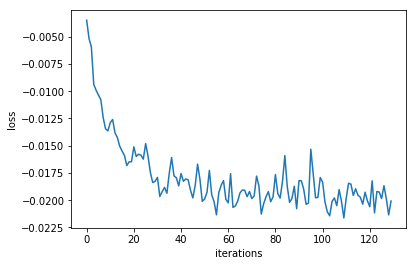

In [54]:
plt.plot(pset.get_variable('loss'))
plt.xlabel('iterations'), plt.ylabel('loss')
plt.show()

save the model if needed

In [55]:
model = pset.get_model_by_name('model')

In [ ]:
# model.save("/notebooks/koryagin/saved_models/cube_p")

# Validation

In this section we look at predictions of our model on *ilines* of the cube we haven't used for training.

In [57]:
from utils import get_lines_range

In [58]:
tflow = (Pipeline()
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('test_sample'), size=32),
               shape=(128, 1, 128),
               passdown=['geometries', 'labels'])
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes'))

In [59]:
test_batch = (qbset >> tflow).next_batch(1)

In [60]:
import tensorflow as tf

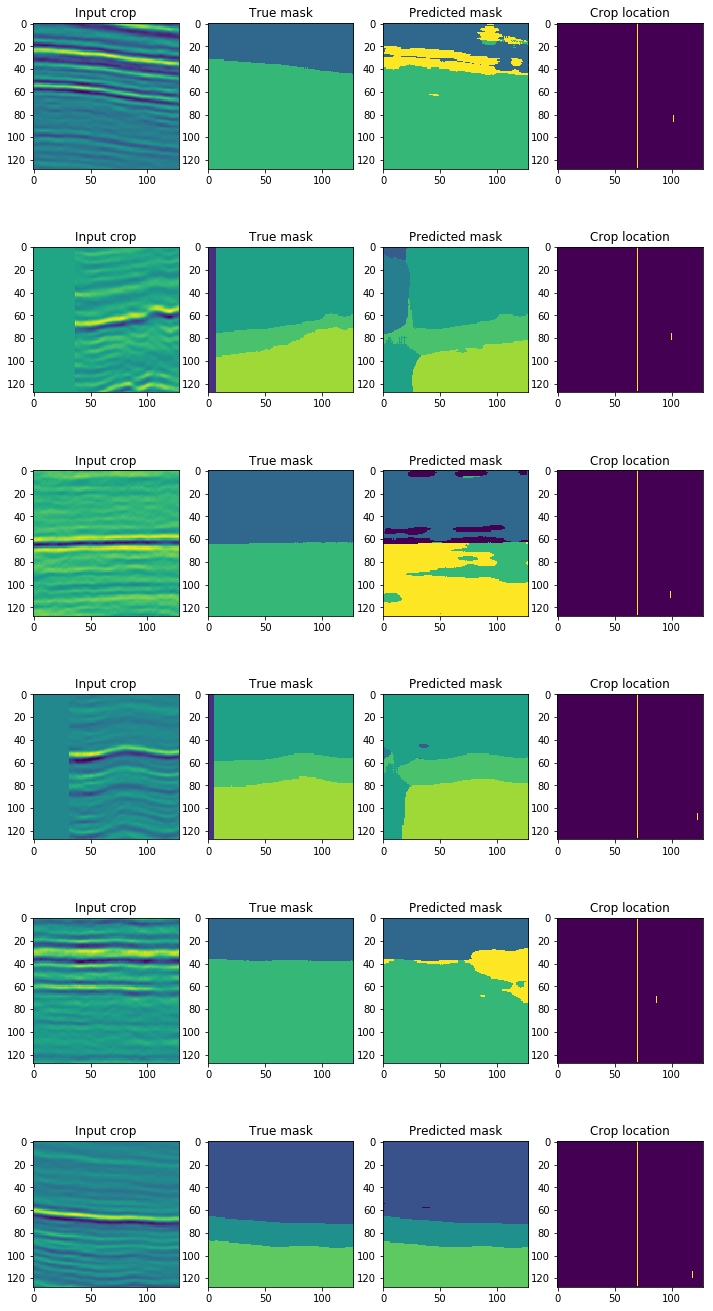

In [62]:
unet = pset.get_model_by_name('model')
targets, predictions = unet.predict(fetches=['targets', 'predictions'],
                                    cubes=test_batch.cubes, masks=test_batch.masks)
n_rows = 6
figs, axes = plt.subplots(n_rows, 4, figsize=(3 * 4, n_rows * 4))
for i, nr in enumerate([1, 2, 3, 4, 5, 7]):
    vmin, vmax = np.min(targets.argmax(axis=-1)[nr,...]) - 1, np.max(targets.argmax(axis=-1)[nr,...]) + 1
    axes[i, 0].imshow(test_batch.cubes[nr,...,0].T)
    axes[i, 1].imshow(targets.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)
    axes[i, 2].imshow(predictions.argmax(axis=-1)[nr,...].T, vmin=vmin, vmax=vmax)

    axes[i, 0].set_title('Input crop')
    axes[i, 1].set_title('True mask')
    axes[i, 2].set_title('Predicted mask')
    axes[i, 3].set_title('Crop location')
    
    ir, xr = get_lines_range(test_batch, nr)
    ir = np.round([128 * ir[0], 128 * ir[1]]).astype(np.int32)
    xr = np.round([128 * xr[0], 128 * xr[1]]).astype(np.int32)
    locs = np.zeros((128, 128), dtype=np.float64)
    locs[ir[0]:ir[1], xr[0]:xr[1] + 1] = 1
    locs[0:-1, np.int(0.55 * 128)] = 1
    axes[i, 3].imshow(locs)

* prediction on full slice

In [151]:
qbset.make_grid('P_cube', [128, 1, 128],
                [0, 2736], [400, 401], [0, 2000])

In [152]:
tflow = (Pipeline()
         # preprocessing
         .load_component([D('labels'), D('geometries')],
                         ['labels', 'geometries'])
         .crop(points=L(D('grid_gen')), shape=(128, 1, 128))
         .load_cubes(dst='cubes')
         .create_masks(dst='masks', mode='stratum')
         .apply_transform(lambda a: a.astype(np.int32).squeeze(), src='masks', dst='masks')
         .apply_transform(lambda a: a.swapaxes(1, 2), src='cubes', dst='cubes')
         .import_model('model', pset)
         # fetching model-predictions
         .init_variables({'cubes': {'init_on_each_run': list()}, 'masks': {'init_on_each_run': list()},
                          'predictions': {'init_on_each_run': list()},
                          'predictions_amax': {'init_on_each_run': list()},
                          'masks_3d': {'init_on_each_run': list()}})
         .predict_model('model',
                        fetches=['cubes', 'masks', 'predictions'],
                        cubes=B('cubes'), masks=B('masks'),
                        save_to=[V('cubes'), V('masks'), V('predictions')], mode='e')
         .update_variable('predictions_amax',
                          L(lambda lst: [targets.argmax(axis=-1)[..., np.newaxis] for targets in lst],
                            V('predictions')))
         .update_variable('masks_3d', L(lambda lst: [targets[..., np.newaxis] for targets in lst],
                                        V('masks')))
         # assembling crops into full-sized ilines
         .assemble_crops(src=V('cubes'), dst='assembled_cube',
                         grid_info=D('grid_info'), order=(0, 2, 1))
         .assemble_crops(src=V('predictions_amax'), dst='assembled_pred',
                         grid_info=D('grid_info'), order=(0, 2, 1))
         .assemble_crops(src=V('masks_3d'), dst='assembled_mask',
                         grid_info=D('grid_info'), order=(0, 2, 1)))

In [153]:
testline = (qbset >> tflow)

In [ ]:
from tqdm import tqdm
for _ in tqdm(range(qbset.grid_iters)):
    pred_batch = testline.next_batch(1, n_epochs=None)

In [ ]:
pred_batch.assembled_cube.shape

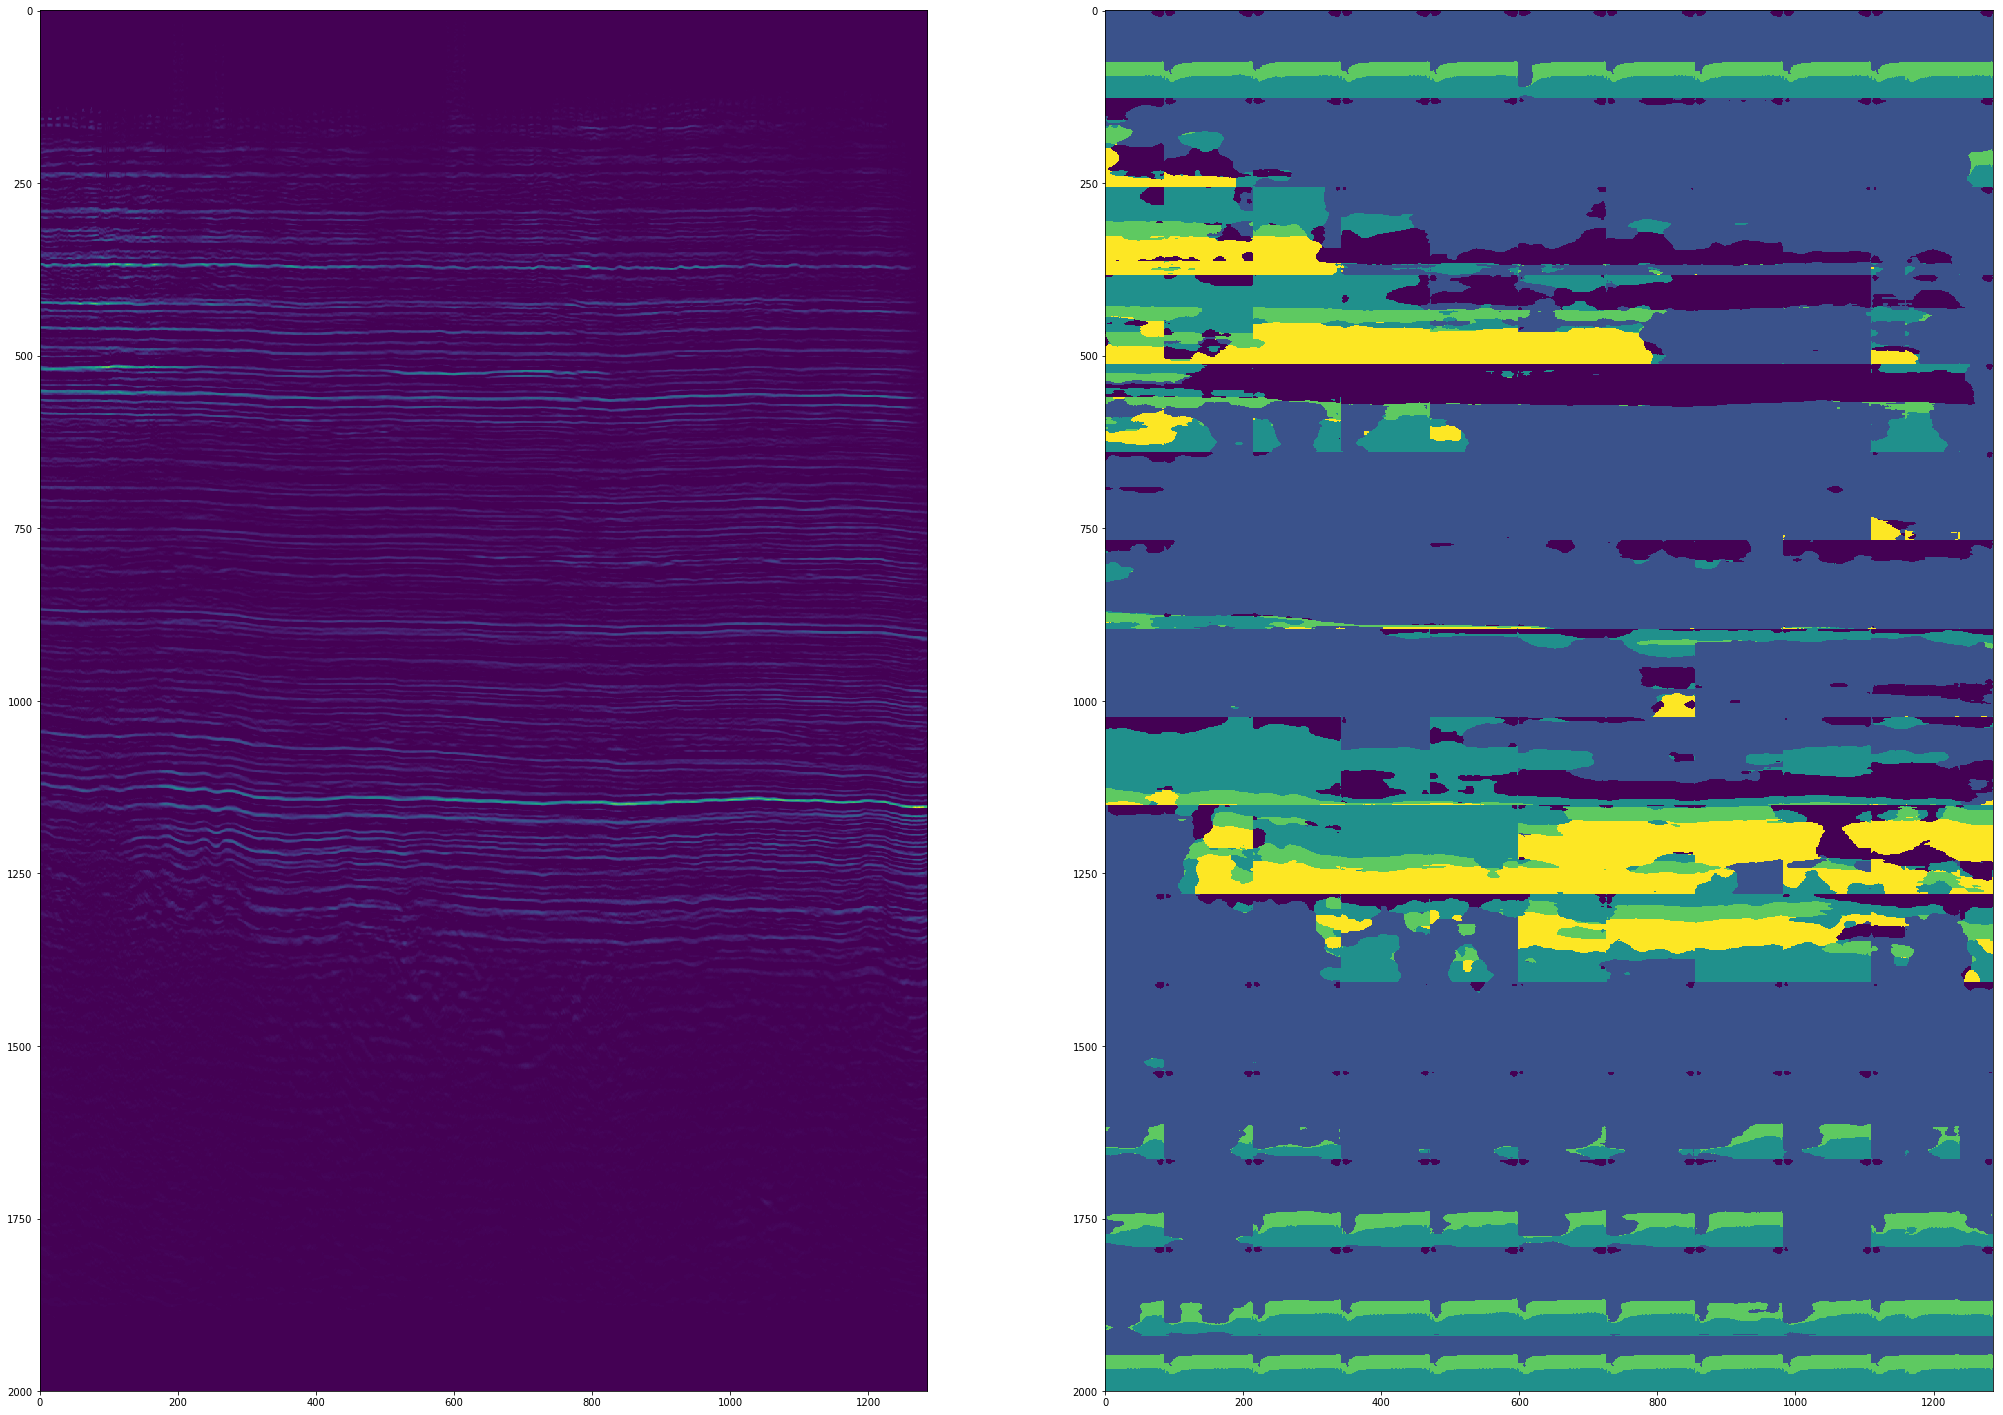

In [134]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred
fig, ax = plt.subplots(1, 2, figsize=(35, 35))
ax[0].imshow(img_full[1450:, 0, :].T)
ax[1].imshow(pred_full[1450:, 0, :].T)
plt.show()

# Criticism

# Conclusion

# Suggestions for improvments